Loading images...
Loaded: 1000 images. Feature dim: 16384
Original dim: 16384 Reduced dim: 50
Setting up SOM: 50 x 50  device: cuda
Training SOM...


Training SOM: 100%|██████████| 50/50 [00:32<00:00,  1.55epoch/s]
c:\Users\Orhan Bayrak\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Orhan Bayrak\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


SOM training finished. QE: [2.106635570526123, 3.47782826423645, 4.617986679077148, 5.529868125915527, 6.30421257019043, 6.982588768005371, 7.566797256469727, 8.03272533416748, 8.466289520263672, 8.82619571685791, 9.15107250213623, 9.426142692565918, 9.65322494506836, 9.873641014099121, 10.040066719055176, 10.173550605773926, 10.32058334350586, 10.449759483337402, 10.550752639770508, 10.677783012390137, 10.745739936828613, 10.822997093200684, 10.873579025268555, 10.944732666015625, 10.997049331665039, 11.054241180419922, 11.077542304992676, 11.120328903198242, 11.140714645385742, 11.177562713623047, 11.194814682006836, 11.23523235321045, 11.195169448852539, 11.225791931152344, 11.256771087646484, 11.250609397888184, 11.273604393005371, 11.253133773803711, 11.277588844299316, 11.256937980651855, 11.257113456726074, 11.271681785583496, 11.263214111328125, 11.239923477172852, 11.261682510375977, 11.252500534057617, 11.229494094848633, 11.213591575622559, 11.216618537902832, 11.21901226043

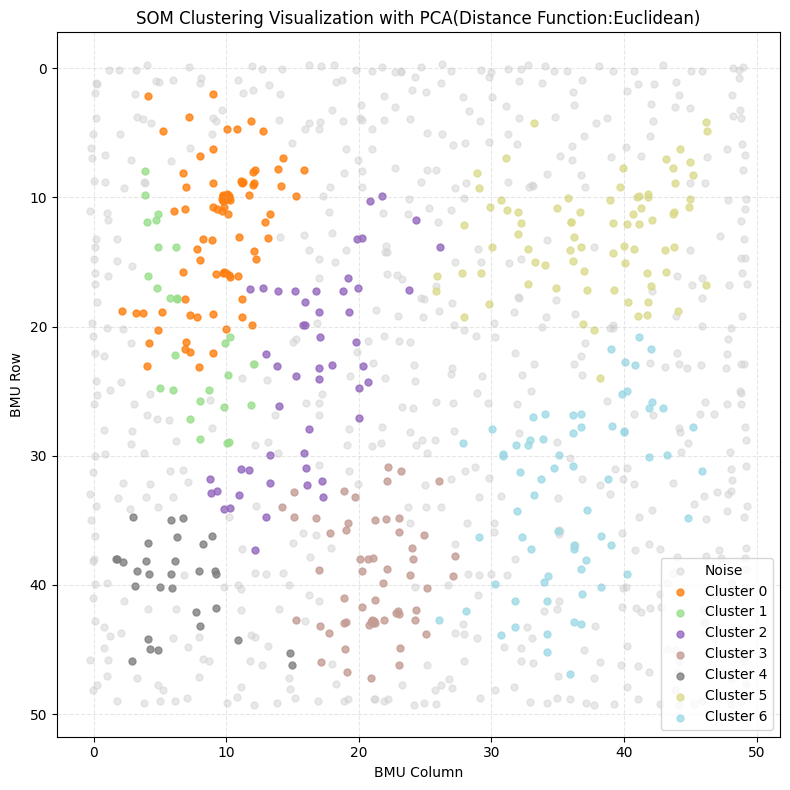

2D scatter plot saved to: C:\Users\Orhan Bayrak\Desktop\UGR Internship\som_run\som_clusters_scatter.png
Done. All outputs in: C:\Users\Orhan Bayrak\Desktop\UGR Internship\som_run


In [ ]:
# SOM + (H)DBSCAN pipeline for images (grayscale) with PCA
# Requirements:
#   pip install torchsom hdbscan scikit-learn matplotlib pillow pandas

import os, math, json, shutil
from pathlib import Path
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
import pandas as pd

# Optional HDBSCAN
try:
    import hdbscan
    HAVE_HDBSCAN = True
except Exception:
    HAVE_HDBSCAN = False

# TorchSOM
try:
    from torchsom.core import SOM
    import torch
except Exception as e:
    raise ImportError("TorchSOM veya torch bulunamadı. `pip install torchsom torch` yapın.") from e

# ----------------------------
# 0) CONFIG 
# ----------------------------
folder = r"C:\Users\Orhan Bayrak\Downloads\cat_data"
img_size = (128,128)
grayscale = True
som_x, som_y = 50, 50
epochs = 50
batch_size = 64
som_device = 'cuda'
init_mode = 'random'
som_learning_rate = 0.5
som_sigma = 2.0
random_seed = 42

# PCA params
pca_components = 50   

# clustering params
use_hdbscan_if_available = True
dbscan_eps = 1.5
dbscan_min_samples = 8
hdbscan_min_cluster_size = 20
hdbscan_min_samples = None

out_prefix = Path("som_run")
out_prefix.mkdir(exist_ok=True)

# ----------------------------
# 1) Load & vectorize (grayscale)
# ----------------------------
def load_grayscale_matrix(folder, size=(128,128), grayscale=True):
    paths = []
    feats = []
    for fn in sorted(os.listdir(folder)):
        if fn.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.webp')):
            p = os.path.join(folder, fn)
            try:
                img = Image.open(p)
                img = img.convert("L") if grayscale else img.convert("RGB")
                img = img.resize(size, Image.BILINEAR)
                arr = np.asarray(img, dtype=np.float32) / 255.0
                vec = arr.reshape(-1)
                feats.append(vec)
                paths.append(p)
            except Exception as e:
                print("skip:", p, e)
    X = np.stack(feats, axis=0) if feats else np.zeros((0, size[0]*size[1]), dtype=np.float32)
    return X, paths

print("Loading images...")
X, paths = load_grayscale_matrix(folder, size=img_size, grayscale=grayscale)
N, D = X.shape
print("Loaded:", N, "images. Feature dim:", D)

if N == 0:
    raise SystemExit("No images found - check folder path.")

# ----------------------------
# 2) Mean-center + PCA
# ----------------------------
scaler = StandardScaler(with_mean=True, with_std=False)  # only mean-center
X_centered = scaler.fit_transform(X)

pca = PCA(n_components=pca_components, random_state=random_seed)
X_pca = pca.fit_transform(X_centered)
print("Original dim:", D, "Reduced dim:", X_pca.shape[1])

# ----------------------------
# 3) SOM setup and training
# ----------------------------
print("Setting up SOM:", som_x, "x", som_y, " device:", som_device)
device = torch.device(som_device)
X_tensor = torch.from_numpy(X_pca).float().to(device)

som = SOM(
    x=som_x, y=som_y, num_features=X_pca.shape[1],
    epochs=epochs, batch_size=batch_size,
    learning_rate=som_learning_rate, sigma=som_sigma,
    neighborhood_order=1, topology='rectangular',
    distance_function='euclidean',
    initialization_mode=init_mode,
    device=device,
    random_seed=random_seed
)

try:
    som.initialize_weights(data=X_tensor, mode=init_mode)
except Exception as e:
    print("Warning during initialization:", e)
    print("Falling back to random init.")
    som.initialize_weights(data=X_tensor, mode='random')

print("Training SOM...")
QE, TE = som.fit(data=X_tensor)
print("SOM training finished. QE:", QE, "TE:", TE)

# ----------------------------
# 4) Get BMUs
# ----------------------------
try:
    bmus_t = som.identify_bmus(X_tensor)
    bmus = bmus_t.detach().cpu().numpy().astype(int)
except Exception:
    print("identify_bmus not available; using fallback.")
    with torch.no_grad():
        dists = som.forward(X_tensor)
        bmu_idx = torch.argmin(dists, dim=1)
        rows = (bmu_idx // som.x).cpu().numpy().astype(int)
        cols = (bmu_idx % som.x).cpu().numpy().astype(int)
        bmus = np.stack([rows, cols], axis=1)

print("BMUs shape:", bmus.shape)

# ----------------------------
# 5) Clustering
# ----------------------------
coords = bmus

if HAVE_HDBSCAN and use_hdbscan_if_available:
    print("Clustering with HDBSCAN...")
    clusterer = hdbscan.HDBSCAN(min_cluster_size=hdbscan_min_cluster_size,
                                min_samples=hdbscan_min_samples,
                                metric='euclidean')
    labels = clusterer.fit_predict(coords)
else:
    print("Clustering with DBSCAN...")
    clusterer = DBSCAN(eps=dbscan_eps, min_samples=dbscan_min_samples, metric='euclidean')
    labels = clusterer.fit_predict(coords)

unique_labels, counts = np.unique(labels, return_counts=True)
print("Clusters:", dict(zip(unique_labels.tolist(), counts.tolist())))
noise_count = int(np.sum(labels == -1))
print(f"Total: {N}, Noise: {noise_count} ({noise_count/N:.1%})")

# ----------------------------
# 6) Save CSV + params JSON
# ----------------------------
params = {
    "dataset": str(Path(folder).resolve()),
    "N": int(N), "feature_dim": int(D),
    "som": {"x": som_x, "y": som_y, "epochs": epochs, "batch_size": batch_size,
            "init_mode": init_mode, "device": str(device), "learning_rate": som_learning_rate, "sigma": som_sigma},
    "clustering": {"method": "HDBSCAN" if (HAVE_HDBSCAN and use_hdbscan_if_available) else "DBSCAN",
                   "dbscan_eps": dbscan_eps, "dbscan_min_samples": dbscan_min_samples,
                   "hdbscan_min_cluster_size": hdbscan_min_cluster_size, "hdbscan_min_samples": hdbscan_min_samples},
    "pca": {"components": pca_components}
}

out_csv = out_prefix / "som_clusters.csv"
df = pd.DataFrame({
    "filepath": paths,
    "bmu_row": bmus[:,0],
    "bmu_col": bmus[:,1],
    "cluster": labels
})
df.to_csv(out_csv, index=False)
with open(out_prefix / "som_run_params.json", "w") as f:
    json.dump(params, f, indent=2)
print("Saved CSV:", out_csv.resolve())
print("Saved params JSON:", (out_prefix / "som_run_params.json").resolve())

# ----------------------------
# 7) 2D scatter plot
# ----------------------------
plt.figure(figsize=(8,8))
jitter = 0.3
unique_labels = np.unique(labels)
colors = plt.cm.tab20(np.linspace(0, 1, len(unique_labels)))

for lbl, color in zip(unique_labels, colors):
    mask = (labels == lbl)
    x = bmus[mask,1] + np.random.uniform(-jitter,jitter,size=np.sum(mask))
    y = bmus[mask,0] + np.random.uniform(-jitter,jitter,size=np.sum(mask))
    if lbl == -1:
        plt.scatter(x, y, c='lightgray', s=25, alpha=0.5, label='Noise')
    else:
        plt.scatter(x, y, c=[color], s=25, alpha=0.8, label=f'Cluster {lbl}')

plt.xlabel("BMU Column")
plt.ylabel("BMU Row")
plt.title("SOM Clustering Visualization with PCA(Distance Function:Euclidean)")
plt.gca().invert_yaxis()
plt.grid(True, linestyle="--", alpha=0.3)
plt.legend()
plt.tight_layout()

out_png = out_prefix / "som_clusters_scatter.png"
plt.savefig(out_png, dpi=200)
plt.show()
print("2D scatter plot saved to:", out_png.resolve())

print("Done. All outputs in:", out_prefix.resolve())


Top-right clusters: [-1  2  5  6]
Bottom-left clusters: [-1  1  2  3  4]


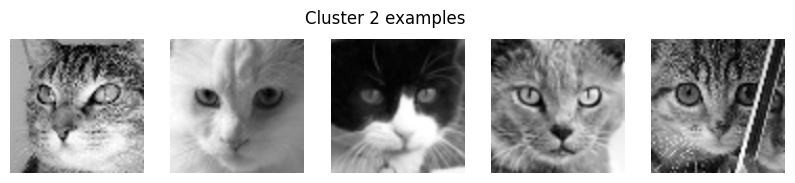

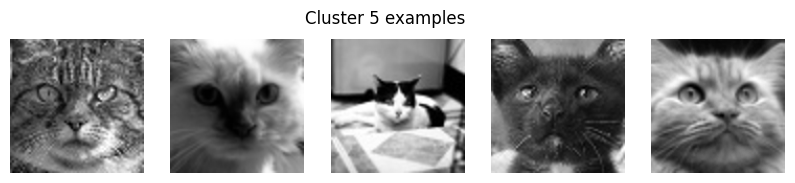

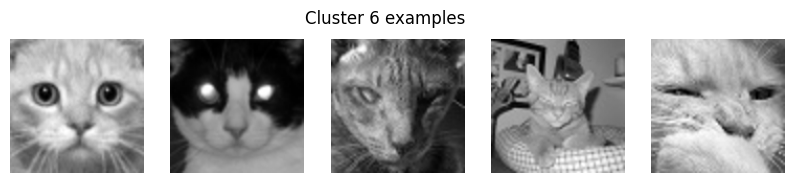

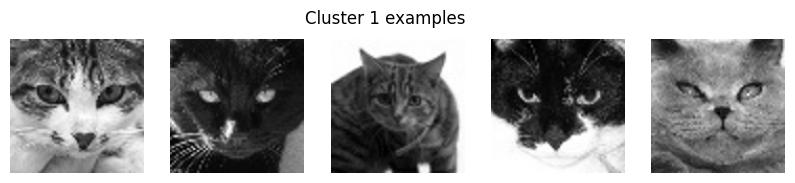

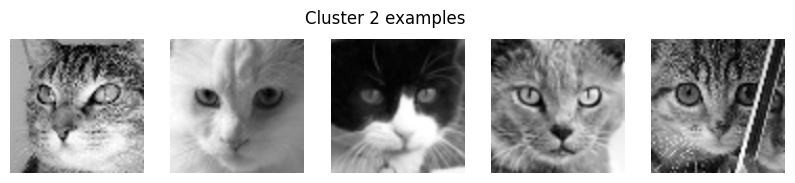

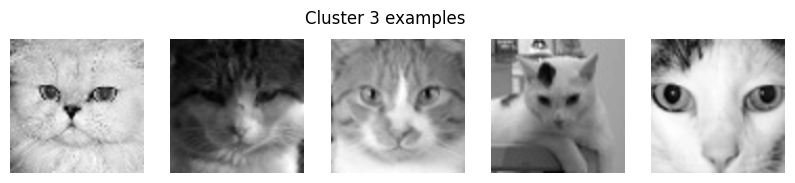

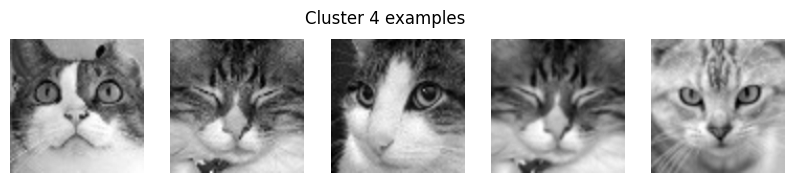

In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

top_right_mask = (bmus[:,0] < som_y//2) & (bmus[:,1] > som_x//2)
bottom_left_mask = (bmus[:,0] > som_y//2) & (bmus[:,1] < som_x//2)

top_right_clusters = np.unique(labels[top_right_mask])
bottom_left_clusters = np.unique(labels[bottom_left_mask])

print("Top-right clusters:", top_right_clusters)
print("Bottom-left clusters:", bottom_left_clusters)

# Example images
def show_cluster_examples(cluster_label, n=5):
    idxs = np.where(labels == cluster_label)[0][:n]
    plt.figure(figsize=(n*2,2))
    for i, idx in enumerate(idxs):
        img = Image.open(paths[idx]).convert("L").resize((128,128))
        plt.subplot(1,n,i+1)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
    plt.suptitle(f"Cluster {cluster_label} examples")
    plt.show()

# Top-right cluster examples
for c in top_right_clusters:
    if c == -1: continue
    show_cluster_examples(c, n=5)

# Bottom-left cluster examples
for c in bottom_left_clusters:
    if c == -1: continue
    show_cluster_examples(c, n=5)